# ball-tree-distance

In [ ]:
import glob

import numpy as np
from astropy import units as u
from astropy.coordinates import Distance, SkyCoord
from astropy.io import fits
from sklearn.neighbors import BallTree

######################################
dir_res = '/Users/astro/Documents/notebooks/zs/cross_match/cross_match_res/v6/'
dir_drp = '/Users/astro/Documents/notebooks/manga/spectro/analysis/MPL-8/drpall-v2_5_3.fits'
dir_dr7 = '/Users/astro/Documents/notebooks/zs/data/dr7_all.fits'


def distance(X1, X2, max_r):

    X1 = X1 * (np.pi / 180.)
    X2 = X2 * (np.pi / 180.)
    max_distance = max_r * (np.pi / 180.)

    # Convert 2D RA/DEC to 3D cartesian coordinates
    Y1 = np.transpose(
        np.vstack([
            np.cos(X1[0]) * np.cos(X1[1]),
            np.sin(X1[0]) * np.cos(X1[1]),
            np.sin(X1[1])
        ]))
    Y2 = np.transpose(
        np.vstack([
            np.cos(X2[:, 0]) * np.cos(X2[:, 1]),
            np.sin(X2[:, 0]) * np.cos(X2[:, 1]),
            np.sin(X2[:, 1])
        ]))

    # law of cosines to compute 3D distance
    max_y = np.sqrt(2 - 2 * np.cos(max_distance))

    tree = BallTree(Y2)
    num = tree.query_radius(Y1, r=max_distance, count_only=True)
    ind, dist = tree.query_radius(Y1,
                                  r=max_distance,
                                  count_only=False,
                                  return_distance=True)
    return num, ind, dist


def r2arcsec(r):
    return r * 180 / np.pi


def max_dis_deg(z):
    '''
    150kpc ~= degree
    '''
    dis = cosmo.comoving_distance(z)  # Mpc
    r = 0.15 / dis.value
    max_r = r2arcsec(r)  # degree
    return max_r


def cross():
    with fits.open(dir_drp) as f_drp, fits.open(dir_dr7) as f_dr7:

        data = f_drp[1].data
        manga = np.empty((len(data), 2), dtype=np.float64)
        manga[:, 0] = data['objra']
        manga[:, 1] = data['objdec']
        manga_z = data['z']
        plateifu = data['plateifu']

        data1 = f_dr7[1].data
        dr7 = np.empty((len(data1), 2), dtype=np.float64)
        dr7[:, 0] = data1['RA']
        dr7[:, 1] = data1['DEC']
        dr7_z = data1['Z']

        for i in range(0, len(manga)):
            pifu = plateifu[i]
            z = manga_z[i]
            max_r = max_dis_deg(z)
            num, ind, dist = distance(manga[i], dr7, max_r)
            array = []
            names = [
                'plateifu', 'manga_ra', 'manga_dec', 'manga_z', 'dr7_index',
                'dr7_ra', 'dr7_dec', 'dr7_z', 'distance', 'max_r'
            ]
            dtype=['U11','f8','f8','f8','i4','f8','f8','i4','f8','f8']
            if num[0] > 0:
                for j in range(0, num[0]):
                    index = ind[0][j]
                    array.append([
                        pifu, manga[i][0], manga[i][1], manga_z[i],index,
                        dr7[index][0], dr7[index][1],dr7_z[index],dist[0][j],max_r
                    ])
#                 print(array)
                array=np.array(array)
                t=Table(array,names=names)
#                 print(t)
                t.write(dir_res+pifu+'.fits',format='fits')
            else:
                with open(dir_res+'no_match.txt','a+') as f:
                    print(pifu,file=f)
if __name__ == '__main__':
    cross()

In [24]:
import numpy as np
import os
from sklearn.neighbors import BallTree
from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo

####################################################################################################
dir_drp = '/Users/astro/Documents/notebooks/manga/spectro/analysis/MPL-8/drpall-v2_5_3.fits'
dir_dr7 = '/Users/astro/Documents/notebooks/zs/data/dr7_all.fits'
dir_k_10_not_enough = '/Users/astro/Documents/notebooks/zs/cross_match/cross_match_res/v5/cmatch_10_not_enough.txt'
dir_res = '/Users/astro/Documents/notebooks/zs/cross_match/cross_match_res/v5/'
####################################################################################################


def match(X1, X2, max_distance):
    X1 = X1 * (np.pi / 180.)
    X2 = X2 * (np.pi / 180.)
    max_distance = max_distance * (np.pi / 180.)

    # Convert 2D RA/DEC to 3D cartesian coordinates
    Y1 = np.transpose(
        np.vstack([
            np.cos(X1[0]) * np.cos(X1[1]),
            np.sin(X1[0]) * np.cos(X1[1]),
            np.sin(X1[1])
        ]))
    Y2 = np.transpose(
        np.vstack([
            np.cos(X2[:, 0]) * np.cos(X2[:, 1]),
            np.sin(X2[:, 0]) * np.cos(X2[:, 1]),
            np.sin(X2[:, 1])
        ]))

    max_r = np.sqrt(2 - 2 * np.cos(max_distance))

    tree = BallTree(Y2)
    num = tree.query_radius(Y1, r=max_r, count_only=True)
    ind = tree.query_radius(Y1, r=max_r)
    return num, ind


def r2arcsec(r):
    return r * 180 / np.pi


def max_dis_deg(z):
    '''
    150kpc ~= degree
    '''
    dis = cosmo.comoving_distance(z)  # Mpc
    r = 0.15 / dis.value
    max_r = r2arcsec(r)  # degree
    return max_r


def cmatch():
    with fits.open(dir_drp) as f_drp, fits.open(dir_dr7) as f_dr7:

        data = f_drp[1].data
        manga = np.empty((len(data), 2), dtype=np.float64)
        manga[:, 0] = data['objra']
        manga[:, 1] = data['objdec']
        manga_z = data['z']
        plateifu = data['plateifu']

        data1 = f_dr7[1].data
        dr7 = np.empty((len(data1), 2), dtype=np.float64)
        dr7[:, 0] = data1['RA']
        dr7[:, 1] = data1['DEC']
        dr7_z = data1['Z']

        for i in range(0,len(manga)):
            
            z = manga_z[i]
            pifu = plateifu[i]
            if os.path.exists(dir_res+pifu+'.fits'):
                continue
            else:
                max_r = max_dis_deg(z)
                num,ind = match(manga[i],dr7,max_r)
                array=[]
                names=['ra','dex','z','index']
                if num[0]>0:
                    for j in range(0,num[0]):

                        index=ind[0][j]
                        array.append([dr7[index,0],dr7[index,1],dr7_z[index],index])

                    array=np.array(array)
                    t=Table(array,names=names,dtype=['f8','f8','f8','i4'])
                    t.write(dir_res+pifu+'.fits',format='fits')
                else:
                    with open(dir_res+'no_match.txt','a+') as f:
                        print(plateifu[i],file=f)
            
if __name__=='__main__':
    cmatch()

/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astro

/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astro

/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astro

/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astro

/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astro

/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astro

/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astro

/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astro

/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/Users/astro/.local/miniconda3/envs/public/lib/python3.7/site-packages/astro

## test_distance

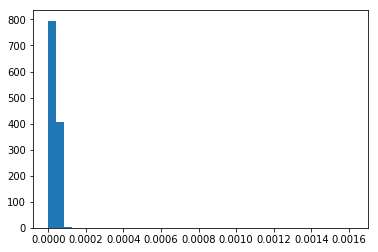

In [17]:

import glob
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import Distance, SkyCoord
from astropy.io import fits

dir_res = '/Users/astro/Documents/notebooks/zs/cross_match/cross_match_res/v6/'
dir_drp = '/Users/astro/Documents/notebooks/manga/spectro/analysis/MPL-8/drpall-v2_5_3.fits'
dir_dr7 = '/Users/astro/Documents/notebooks/zs/data/dr7_all.fits'
dir_distest=dir_res+'distance_test/'

file=glob.glob(dir_res+'*fits')
array=[]
with fits.open('/Users/astro/Documents/notebooks/manga/spectro/analysis/MPL-8/drpall-v2_5_3.fits') as f_drp:
    data_drp=f_drp[1].data
    plateifu_drp=data_drp['plateifu']
    ra_drp=data_drp['objra']
    dec_drp=data_drp['objdec']
    z=data_drp['z']
    for filename in file:
        plateifu=filename[len(dir_res):-5]
#         print(plateifu)
        index=np.where(plateifu_drp==plateifu)[0]
        ra1=ra_drp[index]
        dec1=dec_drp[index]
        z1=z[index]
        dis=Distance(z=z1).value
        theta=0.15/(dis)
        with fits.open(filename) as f:
            data=f[1].data
            ra=data['dr7_ra']
            dec=data['dr7_dec']
            
            # str to float
            ra=[float(n) for n in ra]
            dec=[float(m) for m in dec]
            if len(ra)==0:
                print('null',plateifu)
            else:
#                 print(ra,dec)
                manga=SkyCoord(ra=ra1*u.deg,dec=dec1*u.deg)
                catalog=SkyCoord(ra=ra*u.deg,dec=dec*u.deg)
                dis=manga.separation(catalog).radian
                dis_max=np.max(dis)

                if dis_max<=theta:
                    continue
                else:
                    with open(dir_distest+plateifu+'.txt','a+') as f_test:
                        print(plateifu,dis_max,theta[0],file=f_test)
                        delta_dis=dis_max-theta[0]
                        array.append(delta_dis)
bins=np.linspace(np.min(array),np.max(array)*1.01,num=40)
plt.hist(array,bins=bins)                        
plt.savefig(dir_distest+'delta_dis.png',format='png',dpi=300)
plt.show()

In [28]:
from astropy.coordinates import Distance

dis=Distance(z=0.03)
dis.value

135.79570049977337

# velocity

In [15]:
import glob
import numpy as np
from astropy import units as u
from astropy.coordinates import Distance, SkyCoord
from astropy.io import fits
from astropy.table import Table

dir_res = '/Users/astro/Documents/notebooks/zs/cross_match/cross_match_res/v6/'
dir_drp = '/Users/astro/Documents/notebooks/manga/spectro/analysis/MPL-8/drpall-v2_5_3.fits'
dir_dr7 = '/Users/astro/Documents/notebooks/zs/data/dr7_all.fits'
dir_res1=dir_res+'150_1000/'

file=glob.glob(dir_res+'/*fits')
for filename in file:
    f=Table.read(filename)
    dr7_z=f['dr7_z']
    manga_z=f['manga_z']
    delta_z=[abs(float(n)-float(m)) for n,m in zip(dr7_z,manga_z)]
    delta_z=np.array(delta_z)
    index=np.where(delta_z<1/300)[0]
    pifu=filename[len(dir_res):-5]
    if len(index)>0:
#     print(index)
#     print(f[index])       
        f[index].write(dir_res1+pifu+'.fits',format='fits')
    else:
        with open(dir_res1+'no_match.txt','a+') as f1:
            print(pifu,file=f1)
        

# distribution

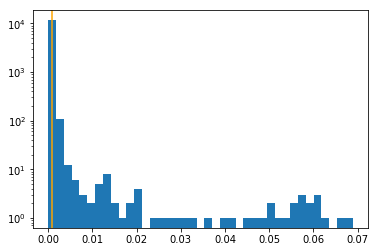

finished


In [16]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import Distance, SkyCoord
from astropy.io import fits
from astropy.table import Table

dir_res = '/Users/astro/Documents/notebooks/zs/cross_match/cross_match_res/v6/'
dir_drp = '/Users/astro/Documents/notebooks/manga/spectro/analysis/MPL-8/drpall-v2_5_3.fits'
dir_dr7 = '/Users/astro/Documents/notebooks/zs/data/dr7_all.fits'
dir_res1=dir_res+'150_1000/'

file=glob.glob(dir_res1+'/*fits')

array=[]
for filename in file:
#     print(filename)
    f=Table.read(filename)
    sepa=f['distance']
    for n in sepa:
        array.append(n)
array=[float(n) for n in array]

bins=np.linspace(np.min(array),np.max(array)*1.01,num=40)
plt.hist(array,bins=bins)
plt.axvline(x=0.00083,color='orange')
plt.yscale('log')
plt.show()
# plt.savefig(dir_res1+'distance_distribution.png',format='png')
print('finished')
# plt.show()
    
        

# remove 3arcsec sourse

In [25]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table

dir_res1='/Users/astro/Documents/notebooks/zs/cross_match/cross_match_res/v6/150_1000/'
dir_res2=dir_res1+'r_larer_than_3arcsec/'

file=glob.glob(dir_res1+'*fits')

critera=3/206265


for filename in file:
        f=Table.read(filename)
        plateifu=filename[len(dir_res1):-5]
        distance=f['distance']
        dis=[float(n) for n in distance]
        print(dis)
        mask=(np.array(dis)>critera)
        f[mask].write(dir_res2+plateifu+'.fits',format='fits')
#         'plateifu', 'manga_ra', 'manga_dec', 'manga_z', 'dr7_index',
#                 'dr7_ra', 'dr7_dec', 'dr7_z', 'distance', 'max_r'
        
        

[3.5850165288716594e-06, 0.0003887904174398208, 0.0003887904174398208, 0.0003887904174398208, 0.0003887904174398208]
[1.734575637089764e-07, 1.734575637089764e-07, 1.734575637089764e-07, 1.734575637089764e-07]


# count number

In [38]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table,unique

dir_res1='/Users/astro/Documents/notebooks/zs/cross_match/cross_match_res/v6/150_1000/'
dir_res2=dir_res1+'r_larer_than_3arcsec/'
dir_res3=dir_res2+'remove_same_source/'

file=glob.glob(dir_res2+'/*.fits')

for filename in file:
    plateifu=filename[len(dir_res2):-5]
    f=Table.read(filename)
    if len(f)>0:
        f1=unique(f,keys=['dr7_ra','dr7_dec'],keep='first')
        f1.write(dir_res3+plateifu+'.fits',format='fits')
    

## distance distribution and num

<Figure size 432x288 with 0 Axes>

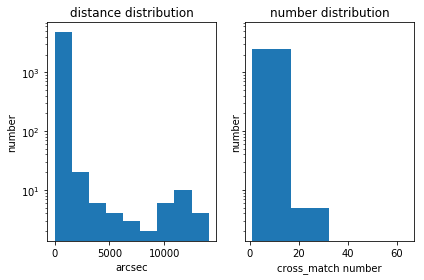

In [48]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table,unique

dir_res1='/Users/astro/Documents/notebooks/zs/cross_match/cross_match_res/v6/150_1000/'
dir_res2=dir_res1+'r_larer_than_3arcsec/'
dir_res3=dir_res2+'remove_same_source/'

file=glob.glob(dir_res3+'/*.fits')

dis=[]
num=[]
for filename in file:
    plateifu=filename[len(dir_res3):-5]
    f=Table.read(filename)
    dis1=f['distance']
    num.append(len(dis1))
    for j in dis1:
        dis.append(j)

dis=[float(n) for n in dis]
dis=[n*206265 for n in dis]
nbins=np.linspace(np.min(dis),np.max(dis),num=10)
plt.figure()
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(dis,bins=nbins)
axs[0].set_yscale('log')
axs[0].set_ylabel('number')
axs[0].set_xlabel('arcsec')
axs[0].set_title('distance distribution')
bin_num=np.linspace(np.min(num),np.max(num),num=5)
axs[1].hist(num,bins=bin_num)
axs[1].set_yscale('log')
axs[1].set_xlabel('cross_match number')
axs[1].set_ylabel('number')
axs[1].set_title('number distribution')
plt.savefig(dir_res3+'distance_distribution.jpg',format='jpg')
plt.show()